In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
import cv2

In [2]:
data = pd.read_csv('fer2013.csv')

# The emotion labels are integers 0-6
# 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Separate pixels and labels
pixels = data['pixels'].tolist()
emotions = data['emotion'].values

# Convert pixel strings to numpy arrays and reshape
images = []
for pixel_sequence in pixels:
    image_data = [int(p) for p in pixel_sequence.split(' ')]
    image_data = np.asarray(image_data).reshape(48, 48)
    images.append(image_data)

images = np.asarray(images)
images = np.expand_dims(images, -1) # Add a channel dimension for Keras

# Convert labels to one-hot encoding
emotions_one_hot = to_categorical(emotions, num_classes=7)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, emotions_one_hot, test_size=0.2, random_state=42)

# Data Augmentation (Feature Engineering)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# You can use RandomOverSampler to address class imbalance if needed
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train_idx = np.argmax(y_train, axis=1)

X_resampled, y_resampled = ros.fit_resample(X_train_flat, y_train_idx)
X_resampled = X_resampled.reshape(-1, 48, 48, 1)
y_resampled = to_categorical(y_resampled, num_classes=7)
print("Original training set shape:", X_train.shape)
print("Resampled training set shape:", X_resampled.shape)


Original training set shape: (28709, 48, 48, 1)
Resampled training set shape: (50568, 48, 48, 1)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define a checkpoint to save the best model
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with augmented data
history = model.fit(
    datagen.flow(X_resampled, y_resampled, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[checkpoint]
)

# The trained model is saved as "best_model.h5"

c:\Users\ADMIN\Project2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,493,063 (9.51 MB)

 Trainable params: 2,491,079 (9.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

c:\Users\ADMIN\Project2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.1952 - loss: 2.6616
Epoch 1: val_accuracy improved from None to 0.28002, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 623s 759ms/step - accuracy: 0.2114 - loss: 2.5012 - val_accuracy: 0.2800 - val_loss: 1.9254
Epoch 2/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.2511 - loss: 2.2276
Epoch 2: val_accuracy improved from 0.28002 to 0.31471, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 590s 746ms/step - accuracy: 0.2628 - loss: 2.1662 - val_accuracy: 0.3147 - val_loss: 1.7757
Epoch 3/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.2969 - loss: 2.0290
Epoch 3: val_accuracy improved from 0.31471 to 0.34661, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 581s 734ms/step - accuracy: 0.3091 - loss: 1.9934 - val_accuracy: 0.3466 - val_loss: 1.8050
Epoch 4/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.3455 - loss: 1.8702
Epoch 4: val_accuracy improved from 0.34661 to 0.39760, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 595s 752ms/step - accuracy: 0.3538 - loss: 1.8414 - val_accuracy: 0.3976 - val_loss: 1.6266
Epoch 5/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.3845 - loss: 1.7374
Epoch 5: val_accuracy did not improve from 0.39760
791/791 ━━━━━━━━━━━━━━━━━━━━ 572s 724ms/step - accuracy: 0.3892 - loss: 1.7224 - val_accuracy: 0.3863 - val_loss: 1.6779
Epoch 6/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.4067 - loss: 1.6550
Epoch 6: val_accuracy did not improve from 0.39760
791/791 ━━━━━━━━━━━━━━━━━━━━ 570s 721ms/step - accuracy: 0.4135 - loss: 1.6362 - val_accuracy: 0.3859 - val_loss: 1.7226
Epoch 7/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4306 - loss: 1.5692
Epoch 7: val_accuracy improved from 0.39760 to 0.46629, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 470s 594ms/step - accuracy: 0.4371 - loss: 1.5521 - val_accuracy: 0.4663 - val_loss: 1.4398
Epoch 8/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.4458 - loss: 1.5085
Epoch 8: val_accuracy improved from 0.46629 to 0.46935, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 572s 723ms/step - accuracy: 0.4536 - loss: 1.4858 - val_accuracy: 0.4694 - val_loss: 1.4522
Epoch 9/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.4719 - loss: 1.4245
Epoch 9: val_accuracy did not improve from 0.46935
791/791 ━━━━━━━━━━━━━━━━━━━━ 604s 764ms/step - accuracy: 0.4732 - loss: 1.4172 - val_accuracy: 0.4673 - val_loss: 1.4776
Epoch 10/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.4897 - loss: 1.3720
Epoch 10: val_accuracy improved from 0.46935 to 0.47478, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 539s 681ms/step - accuracy: 0.4926 - loss: 1.3626 - val_accuracy: 0.4748 - val_loss: 1.4776
Epoch 11/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.5052 - loss: 1.3252
Epoch 11: val_accuracy improved from 0.47478 to 0.47506, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 445s 562ms/step - accuracy: 0.5047 - loss: 1.3231 - val_accuracy: 0.4751 - val_loss: 1.4602
Epoch 12/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.5160 - loss: 1.2895
Epoch 12: val_accuracy improved from 0.47506 to 0.51087, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 441s 557ms/step - accuracy: 0.5183 - loss: 1.2833 - val_accuracy: 0.5109 - val_loss: 1.3196
Epoch 13/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5263 - loss: 1.2635
Epoch 13: val_accuracy improved from 0.51087 to 0.52563, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 439s 555ms/step - accuracy: 0.5306 - loss: 1.2528 - val_accuracy: 0.5256 - val_loss: 1.3008
Epoch 14/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5398 - loss: 1.2258
Epoch 14: val_accuracy improved from 0.52563 to 0.55266, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 439s 555ms/step - accuracy: 0.5409 - loss: 1.2231 - val_accuracy: 0.5527 - val_loss: 1.2259
Epoch 15/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.5495 - loss: 1.1952
Epoch 15: val_accuracy did not improve from 0.55266
791/791 ━━━━━━━━━━━━━━━━━━━━ 439s 555ms/step - accuracy: 0.5509 - loss: 1.1946 - val_accuracy: 0.5401 - val_loss: 1.2745
Epoch 16/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5602 - loss: 1.1761
Epoch 16: val_accuracy did not improve from 0.55266
791/791 ━━━━━━━━━━━━━━━━━━━━ 437s 552ms/step - accuracy: 0.5572 - loss: 1.1783 - val_accuracy: 0.5417 - val_loss: 1.2537
Epoch 17/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.5702 - loss: 1.1507
Epoch 17: val_accuracy did not improve from 0.55266
791/791 ━━━━━━━━━━━━━━━━━━━━ 439s 554ms/step - accuracy: 0.5670 - loss: 1.1549 - val_accuracy: 0.5500 - val_loss: 1.2330
Epoch 18/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.5722 - loss: 1.1398
Epoc

791/791 ━━━━━━━━━━━━━━━━━━━━ 440s 557ms/step - accuracy: 0.5739 - loss: 1.1373 - val_accuracy: 0.5584 - val_loss: 1.2119
Epoch 19/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5740 - loss: 1.1253
Epoch 19: val_accuracy improved from 0.55837 to 0.57008, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 424s 536ms/step - accuracy: 0.5754 - loss: 1.1257 - val_accuracy: 0.5701 - val_loss: 1.1805
Epoch 20/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5834 - loss: 1.1029
Epoch 20: val_accuracy improved from 0.57008 to 0.57537, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 400s 505ms/step - accuracy: 0.5867 - loss: 1.0972 - val_accuracy: 0.5754 - val_loss: 1.1527
Epoch 21/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5921 - loss: 1.0815
Epoch 21: val_accuracy did not improve from 0.57537
791/791 ━━━━━━━━━━━━━━━━━━━━ 396s 501ms/step - accuracy: 0.5913 - loss: 1.0870 - val_accuracy: 0.5659 - val_loss: 1.1888
Epoch 22/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5933 - loss: 1.0764
Epoch 22: val_accuracy improved from 0.57537 to 0.60281, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 397s 501ms/step - accuracy: 0.5951 - loss: 1.0736 - val_accuracy: 0.6028 - val_loss: 1.0886
Epoch 23/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5989 - loss: 1.0603
Epoch 23: val_accuracy did not improve from 0.60281
791/791 ━━━━━━━━━━━━━━━━━━━━ 396s 500ms/step - accuracy: 0.6024 - loss: 1.0572 - val_accuracy: 0.5949 - val_loss: 1.1068
Epoch 24/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6047 - loss: 1.0523
Epoch 24: val_accuracy improved from 0.60281 to 0.60755, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 399s 504ms/step - accuracy: 0.6079 - loss: 1.0451 - val_accuracy: 0.6076 - val_loss: 1.0796
Epoch 25/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6115 - loss: 1.0328
Epoch 25: val_accuracy did not improve from 0.60755
791/791 ━━━━━━━━━━━━━━━━━━━━ 396s 500ms/step - accuracy: 0.6111 - loss: 1.0356 - val_accuracy: 0.5942 - val_loss: 1.1137
Epoch 26/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6167 - loss: 1.0182
Epoch 26: val_accuracy did not improve from 0.60755
791/791 ━━━━━━━━━━━━━━━━━━━━ 396s 501ms/step - accuracy: 0.6165 - loss: 1.0193 - val_accuracy: 0.6004 - val_loss: 1.0902
Epoch 27/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6233 - loss: 1.0091
Epoch 27: val_accuracy did not improve from 0.60755
791/791 ━━━━━━━━━━━━━━━━━━━━ 397s 502ms/step - accuracy: 0.6190 - loss: 1.0130 - val_accuracy: 0.5925 - val_loss: 1.1158
Epoch 28/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6214 - loss: 1.0023
Epoc

791/791 ━━━━━━━━━━━━━━━━━━━━ 398s 504ms/step - accuracy: 0.6224 - loss: 1.0037 - val_accuracy: 0.6102 - val_loss: 1.0643
Epoch 29/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6261 - loss: 0.9960
Epoch 29: val_accuracy did not improve from 0.61020
791/791 ━━━━━━━━━━━━━━━━━━━━ 396s 501ms/step - accuracy: 0.6265 - loss: 0.9935 - val_accuracy: 0.6082 - val_loss: 1.0923
Epoch 30/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6289 - loss: 0.9809
Epoch 30: val_accuracy improved from 0.61020 to 0.61535, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 397s 502ms/step - accuracy: 0.6315 - loss: 0.9811 - val_accuracy: 0.6154 - val_loss: 1.0673
Epoch 31/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6361 - loss: 0.9679
Epoch 31: val_accuracy improved from 0.61535 to 0.61786, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 401s 507ms/step - accuracy: 0.6337 - loss: 0.9756 - val_accuracy: 0.6179 - val_loss: 1.0639
Epoch 32/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6296 - loss: 0.9778
Epoch 32: val_accuracy improved from 0.61786 to 0.62148, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 398s 504ms/step - accuracy: 0.6355 - loss: 0.9699 - val_accuracy: 0.6215 - val_loss: 1.0449
Epoch 33/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6386 - loss: 0.9614
Epoch 33: val_accuracy improved from 0.62148 to 0.62956, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 400s 506ms/step - accuracy: 0.6396 - loss: 0.9595 - val_accuracy: 0.6296 - val_loss: 1.0158
Epoch 34/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6398 - loss: 0.9566
Epoch 34: val_accuracy did not improve from 0.62956
791/791 ━━━━━━━━━━━━━━━━━━━━ 396s 501ms/step - accuracy: 0.6422 - loss: 0.9501 - val_accuracy: 0.6213 - val_loss: 1.0409
Epoch 35/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6474 - loss: 0.9427
Epoch 35: val_accuracy did not improve from 0.62956
791/791 ━━━━━━━━━━━━━━━━━━━━ 398s 503ms/step - accuracy: 0.6451 - loss: 0.9455 - val_accuracy: 0.6255 - val_loss: 1.0309
Epoch 36/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.6511 - loss: 0.9295
Epoch 36: val_accuracy did not improve from 0.62956
791/791 ━━━━━━━━━━━━━━━━━━━━ 403s 510ms/step - accuracy: 0.6505 - loss: 0.9353 - val_accuracy: 0.6289 - val_loss: 1.0191
Epoch 37/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6530 - loss: 0.9245
Epoc

791/791 ━━━━━━━━━━━━━━━━━━━━ 398s 503ms/step - accuracy: 0.6565 - loss: 0.9116 - val_accuracy: 0.6321 - val_loss: 1.0038
Epoch 41/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.6586 - loss: 0.9079
Epoch 41: val_accuracy did not improve from 0.63207
791/791 ━━━━━━━━━━━━━━━━━━━━ 406s 513ms/step - accuracy: 0.6595 - loss: 0.9055 - val_accuracy: 0.6321 - val_loss: 1.0067
Epoch 42/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6591 - loss: 0.9009
Epoch 42: val_accuracy did not improve from 0.63207
791/791 ━━━━━━━━━━━━━━━━━━━━ 429s 543ms/step - accuracy: 0.6612 - loss: 0.9025 - val_accuracy: 0.6305 - val_loss: 1.0077
Epoch 43/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.6650 - loss: 0.8938
Epoch 43: val_accuracy improved from 0.63207 to 0.64085, saving model to best_model.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 401s 507ms/step - accuracy: 0.6634 - loss: 0.8959 - val_accuracy: 0.6408 - val_loss: 0.9938
Epoch 44/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6659 - loss: 0.8894
Epoch 44: val_accuracy did not improve from 0.64085
791/791 ━━━━━━━━━━━━━━━━━━━━ 397s 501ms/step - accuracy: 0.6647 - loss: 0.8902 - val_accuracy: 0.6311 - val_loss: 1.0083
Epoch 45/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6672 - loss: 0.8851
Epoch 45: val_accuracy did not improve from 0.64085
791/791 ━━━━━━━━━━━━━━━━━━━━ 398s 503ms/step - accuracy: 0.6682 - loss: 0.8829 - val_accuracy: 0.6250 - val_loss: 1.0243
Epoch 46/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6673 - loss: 0.8831
Epoch 46: val_accuracy did not improve from 0.64085
791/791 ━━━━━━━━━━━━━━━━━━━━ 397s 502ms/step - accuracy: 0.6663 - loss: 0.8854 - val_accuracy: 0.6399 - val_loss: 0.9886
Epoch 47/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6743 - loss: 0.8723
Epoc

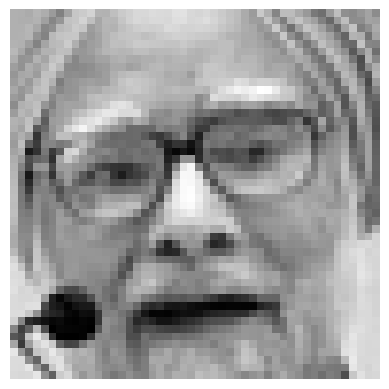

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image_data = [int(p) for p in pixels[1].split(' ')]
image_data = np.asarray(image_data).reshape(48, 48)
plt.imshow(image_data, cmap = "gray")
plt.axis("off")
plt.show()


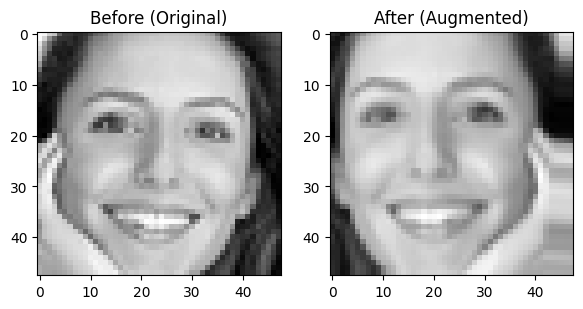

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Pick one image
idx = 2
original = X_train[idx]

# Prepare batch for augmentation
original_batch = np.expand_dims(original, 0)

# Generate ONE augmented image
aug_iter = datagen.flow(original_batch, batch_size=1)
augmented = next(aug_iter)[0]

# Remove channel dimension for display
orig_img = original.squeeze()
aug_img = augmented.squeeze()

# Plot
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(orig_img, cmap='gray')
plt.title("Before (Original)")
#plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(aug_img, cmap='gray')
plt.title("After (Augmented)")
#plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.6408 - loss: 0.9938
Validation Accuracy: 64.08%
Validation Loss: 0.9938


225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step


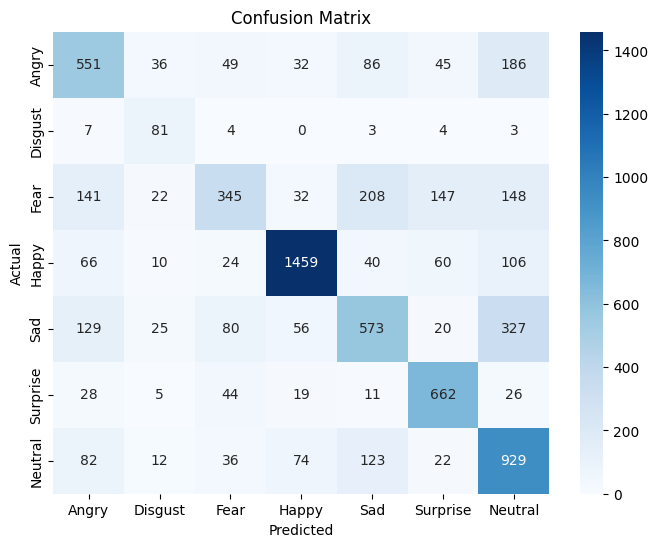

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       985
           1       0.42      0.79      0.55       102
           2       0.59      0.33      0.42      1043
           3       0.87      0.83      0.85      1765
           4       0.55      0.47      0.51      1210
           5       0.69      0.83      0.75       795
           6       0.54      0.73      0.62      1278

    accuracy                           0.64      7178
   macro avg       0.60      0.65      0.61      7178
weighted avg       0.65      0.64      0.63      7178



In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

emotionclasses = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.heatmap(cm, annot=True, fmt='d', xticklabels= emotionclasses,
            yticklabels=emotionclasses, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes))